In [28]:
import matplotlib.pyplot as plt
import aniposelib
%matplotlib widget
import numpy as np
import pandas as pd
import os, cv2, sys, shutil

## Choosing Equidistant Points on a tail

In [29]:
calibration_ = aniposelib.cameras.CameraGroup.load('/mnt/soma_cifs/Iyer/Filming/02112022a/calibrationwater_1515/calibration.toml')

In [58]:
def get_traces(img_n, folder):
    p0 = np.load(f'/home/iyer_la/Documents/TailAnnotated/tadpole_stage57_Cam0-Aditya-2022-11-04/labeled-data/{folder}/Camera1img{img_n}_pts00000.npy')
    p1 = np.load(f'/home/iyer_la/Documents/TailAnnotated/tadpole_stage57_Cam1-Aditya-2022-11-04/labeled-data/{folder}/Camera1img{img_n}_pts00000.npy')
    p2 = np.load(f'/home/iyer_la/Documents/TailAnnotated/tadpole_stage57_Cam2-Aditya-2022-11-04/labeled-data/{folder}/Camera1img{img_n}_pts00000.npy')
    return p0, p1, p2

In [59]:
def get_imgs(img_n, folder):
    p0 = cv2.imread(f'/home/iyer_la/Documents/TailAnnotated/tadpole_stage57_Cam0-Aditya-2022-11-04/labeled-data/{folder}/img{img_n}.png')
    p1 = cv2.imread(f'/home/iyer_la/Documents/TailAnnotated/tadpole_stage57_Cam1-Aditya-2022-11-04/labeled-data/{folder}/img{img_n}.png')
    p2 = cv2.imread(f'/home/iyer_la/Documents/TailAnnotated/tadpole_stage57_Cam2-Aditya-2022-11-04/labeled-data/{folder}/img{img_n}.png')
    return p0, p1, p2

In [32]:
def get_neighbours(shp, curr_):
    x = range(max(0, curr_[0] - 1),min(curr_[0] + 2, shp[0]))
    y = range(max(0, curr_[1] - 1),min(curr_[1] + 2, shp[1]))
    neighbours = np.array(np.meshgrid(x,y)).T.reshape(-1, 2)
    return neighbours

def djikstra_walk(array_, start_, end_):
    '''
    Finds the shortest path through the array_ using Djikstra's algorithm
    '''
    #Initiate all the required arrays
    #curr_ = np.array([0, np.argmin(residuals_[0])])
    curr_ = np.array(start_, dtype = np.int32)
    visited_ = np.zeros(array_.shape, dtype = np.bool_)
    previous_ = np.zeros((array_.shape[0], array_.shape[1], 2), dtype = np.int32)
    previous_[tuple(curr_)] = [-1, -1]
    distances_ = np.ones(array_.shape)*np.inf
    distances_[tuple(curr_)] = array_[tuple(curr_)]
    path_ = []

    while True:
        visited_[tuple(curr_)] = 1
        min_ = np.inf
        neighbours = get_neighbours(array_.shape, curr_)
        for ng in neighbours:
            # Update Distances
            if distances_[tuple(curr_)] + array_[tuple(ng)] < distances_[tuple(ng)]:
                distances_[tuple(ng)] = distances_[tuple(curr_)] + array_[tuple(ng)]
                previous_[tuple(ng)] = curr_
        distances_1 = np.copy(distances_);
        distances_1[np.where(visited_)] = np.inf
        curr_ = np.array(np.unravel_index(np.argmin(distances_1), distances_1.shape))
        if curr_[0] == end_[0] and curr_[1] == end_[1]:
            break
    # Traceback the path from the linked list
    while (curr_ != [-1, -1]).all():
        path_.append(curr_)
        curr_ = previous_[tuple(curr_)]
    path_ = np.flip(path_, axis = 0)

    return path_

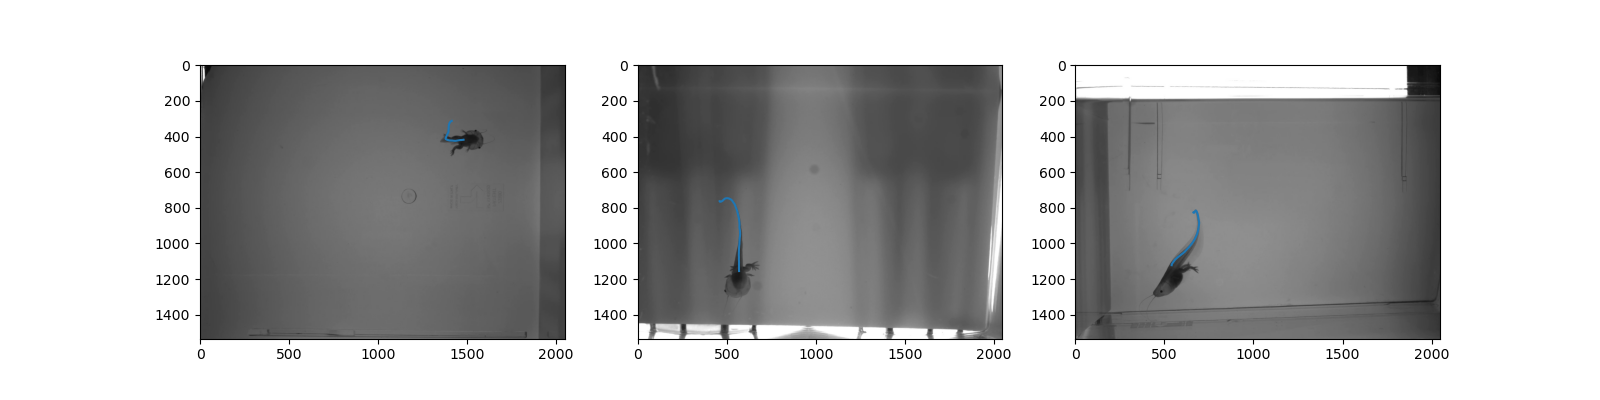

In [146]:
img_n = '1407'
folder = '45_7825-10101'
p0, p1, p2 = get_traces(img_n, folder)
i0, i1, i2 = get_imgs(img_n, folder)
pts_ = np.array([p0, p1, p2]).reshape(3, -1, 2)
fig, ax = plt.subplots(1,3,figsize = (16,4))
ax[0].imshow(i0)
ax[0].plot(p0[:,0], p0[:,1])

ax[1].imshow(i1)
ax[1].plot(p1[:,0], p1[:,1])

ax[2].imshow(i2)
ax[2].plot(p2[:,0], p2[:,1])

In [136]:
# In this case, Camera1 and Camera2 (not Camera0) are more likely to return appropriate correspondences

In [147]:
pts_pairs = np.zeros((3, 100*100, 2))
pts_pairs[0] = np.nan
for i in range(100):
    for j in range(100):
        pts_pairs[1][i*100 + j] = p1[i]
        pts_pairs[2][i*100 + j] = p2[j]

pts3d = calibration_.triangulate(pts_pairs, progress=True)
reproj_err = calibration_.reprojection_error(pts3d, pts_pairs, mean=True)
residuals_ = np.reshape(reproj_err, (100, 100))

100%|█████████████████████████| 10000/10000 [00:05<00:00, 1952.46it/s]


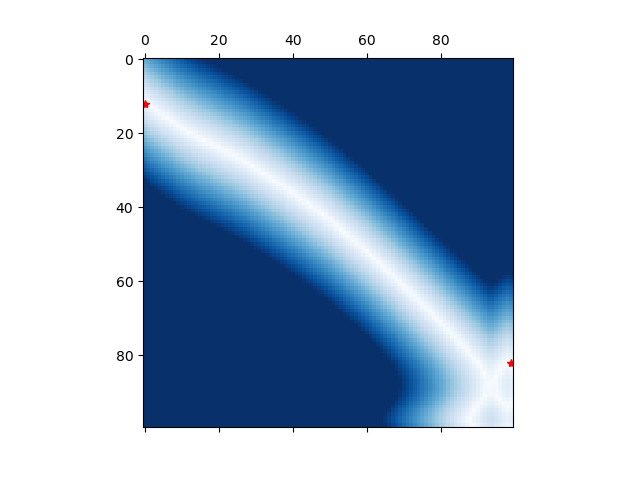

In [148]:
fig, ax = plt.subplots()
ax.matshow(residuals_, cmap = plt.cm.Blues, vmin =0, vmax = 50)
if(min(residuals_[:,0]) < min(residuals_[0])):
    start_ = [np.argmin(residuals_[:,0]), 0]
else:
    start_ = [0, np.argmin(residuals_[0])]
    
plt.plot(start_[1], start_[0], 'r*')

if(min(residuals_[:,99]) < min(residuals_[99])):
    end_ = [np.argmin(residuals_[:,99]), 99]
else:
    end_ = [99, np.argmin(residuals_[99])]
    
plt.plot(end_[1], end_[0], 'r*')

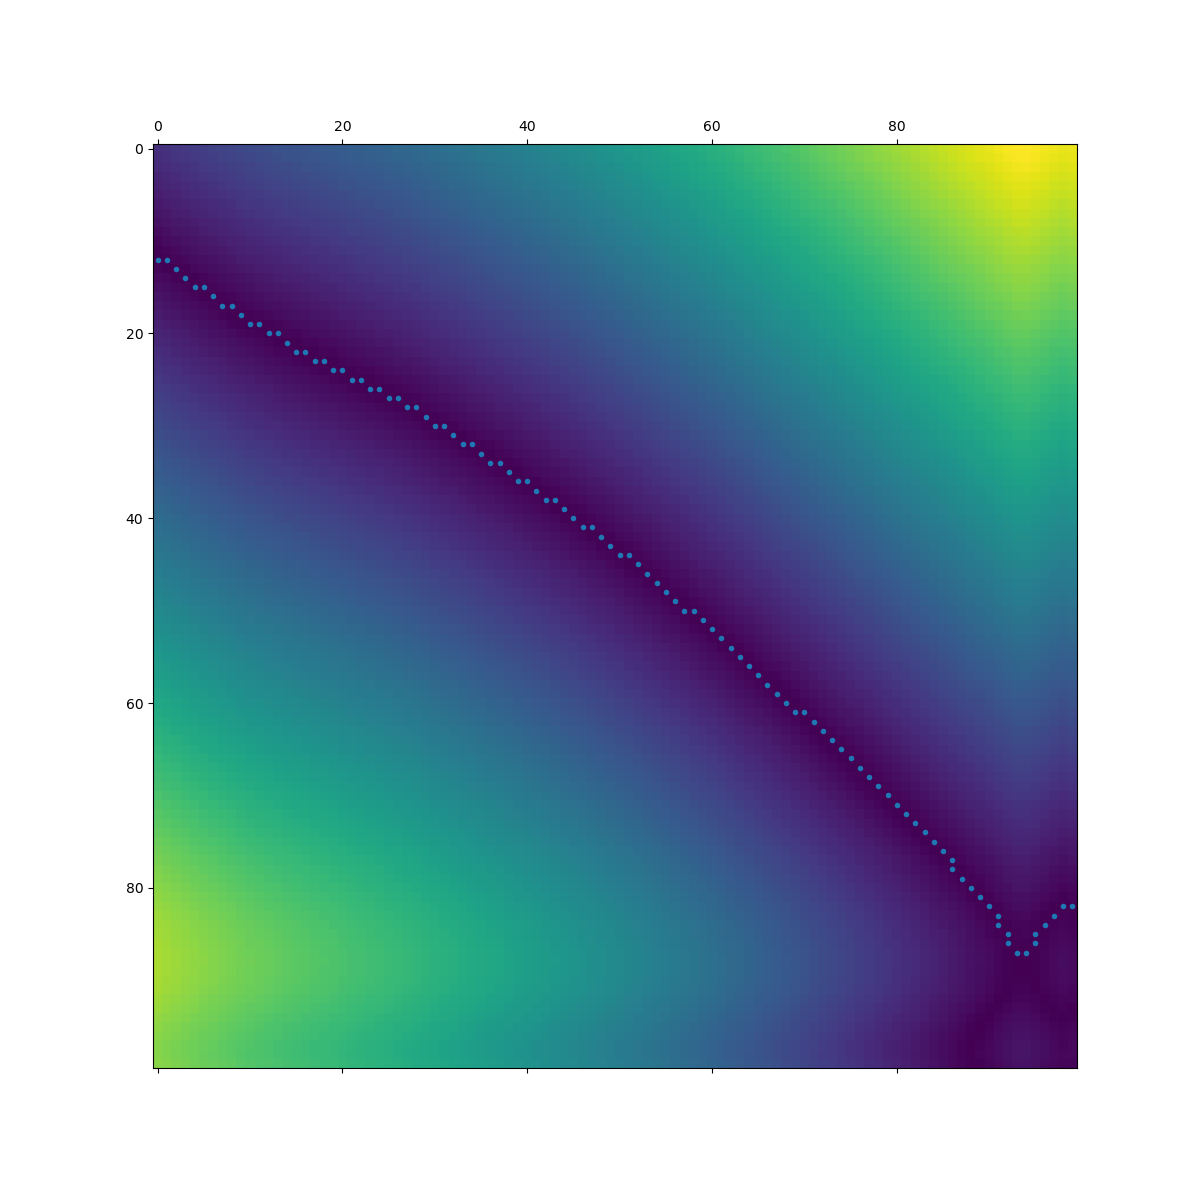

In [149]:
path_ = djikstra_walk(residuals_, start_, end_)
fig, ax = plt.subplots(figsize = (12,12))
ax.matshow(residuals_)
ax.plot(path_[:,1], path_[:,0], '.')

[1.1207499  0.72918434 0.94359717 0.6100185  0.99081083 0.98728262
 1.0841009  0.67444196 0.64397048 0.63095505]


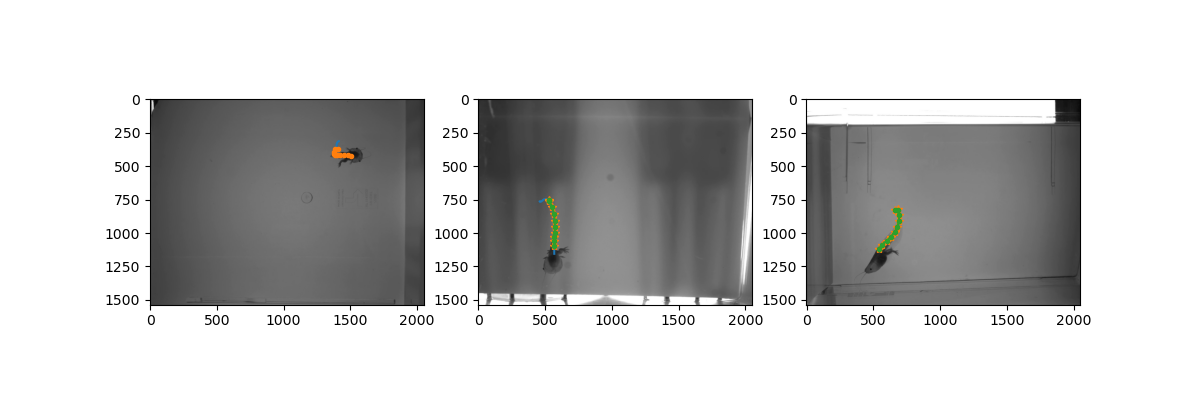

In [150]:
slice_ = np.rint(np.linspace(0, len(path_)-1, 10)).astype(np.int32)
x = path_[slice_,0]
y = path_[slice_,1]
pts_ = np.array([p1[x], p1[x], p2[y]])
pts_[0] = np.nan
tail3d = calibration_.triangulate(pts_)
calibration_.reprojection_error(tail3d, pts_, mean = True)
pts_reproj = calibration_.project(tail3d)


fig, ax = plt.subplots(1,3,figsize = (12,4))
ax[0].imshow(i0)
ax[0].plot(p0[:,0], p0[:,1])
ax[1].plot(p1[:,0], p1[:,1])
ax[2].plot(p2[:,0], p2[:,1])


ax[1].imshow(i1)
ax[1].plot(p1[x,0], p1[x,1], '*')

ax[2].imshow(i2)
ax[2].plot(p2[y,0], p2[y,1], '*')



ax[0].plot(pts_reproj[0][:,0], pts_reproj[0][:,1], '.-')
ax[1].plot(pts_reproj[1][:,0], pts_reproj[1][:,1], '.-')
ax[2].plot(pts_reproj[2][:,0], pts_reproj[2][:,1], '.-')
print(calibration_.reprojection_error(tail3d, pts_, mean = True))

In [122]:
for p in pts_reproj[0]:
    i0 = cv2.circle(i0, p.astype(np.int32), radius=4, color=(0, 255, 255), thickness=-1)
for p in pts_reproj[1]:
    i1 = cv2.circle(i1, p.astype(np.int32), radius=4, color=(0, 255, 255), thickness=-1)
for p in pts_reproj[2]:
    i2 = cv2.circle(i2, p.astype(np.int32), radius=4, color=(0, 255, 255), thickness=-1)

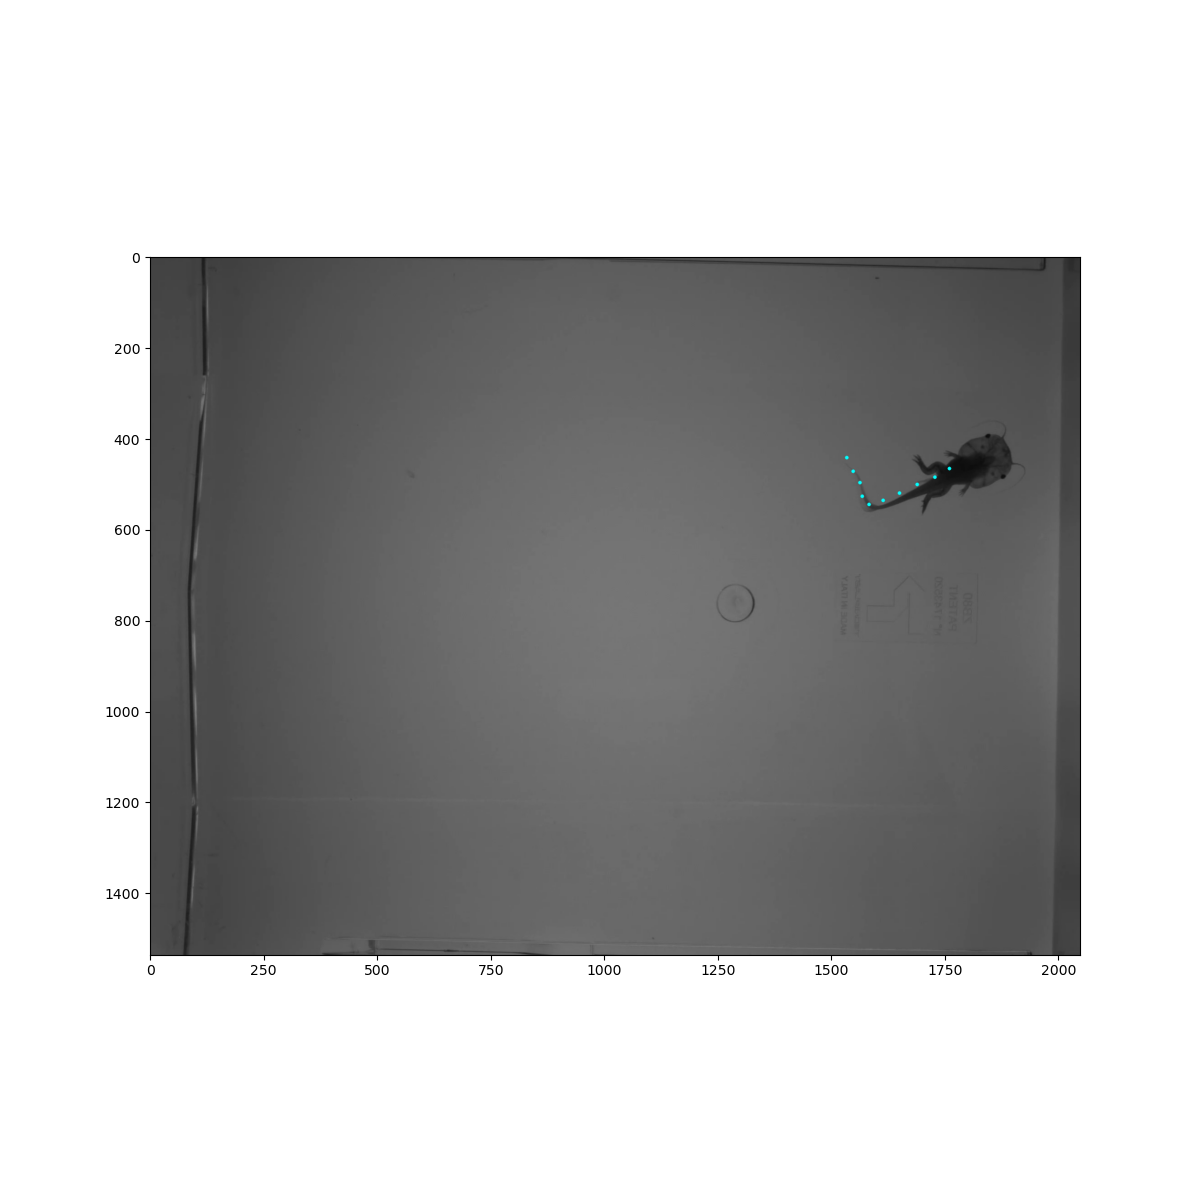

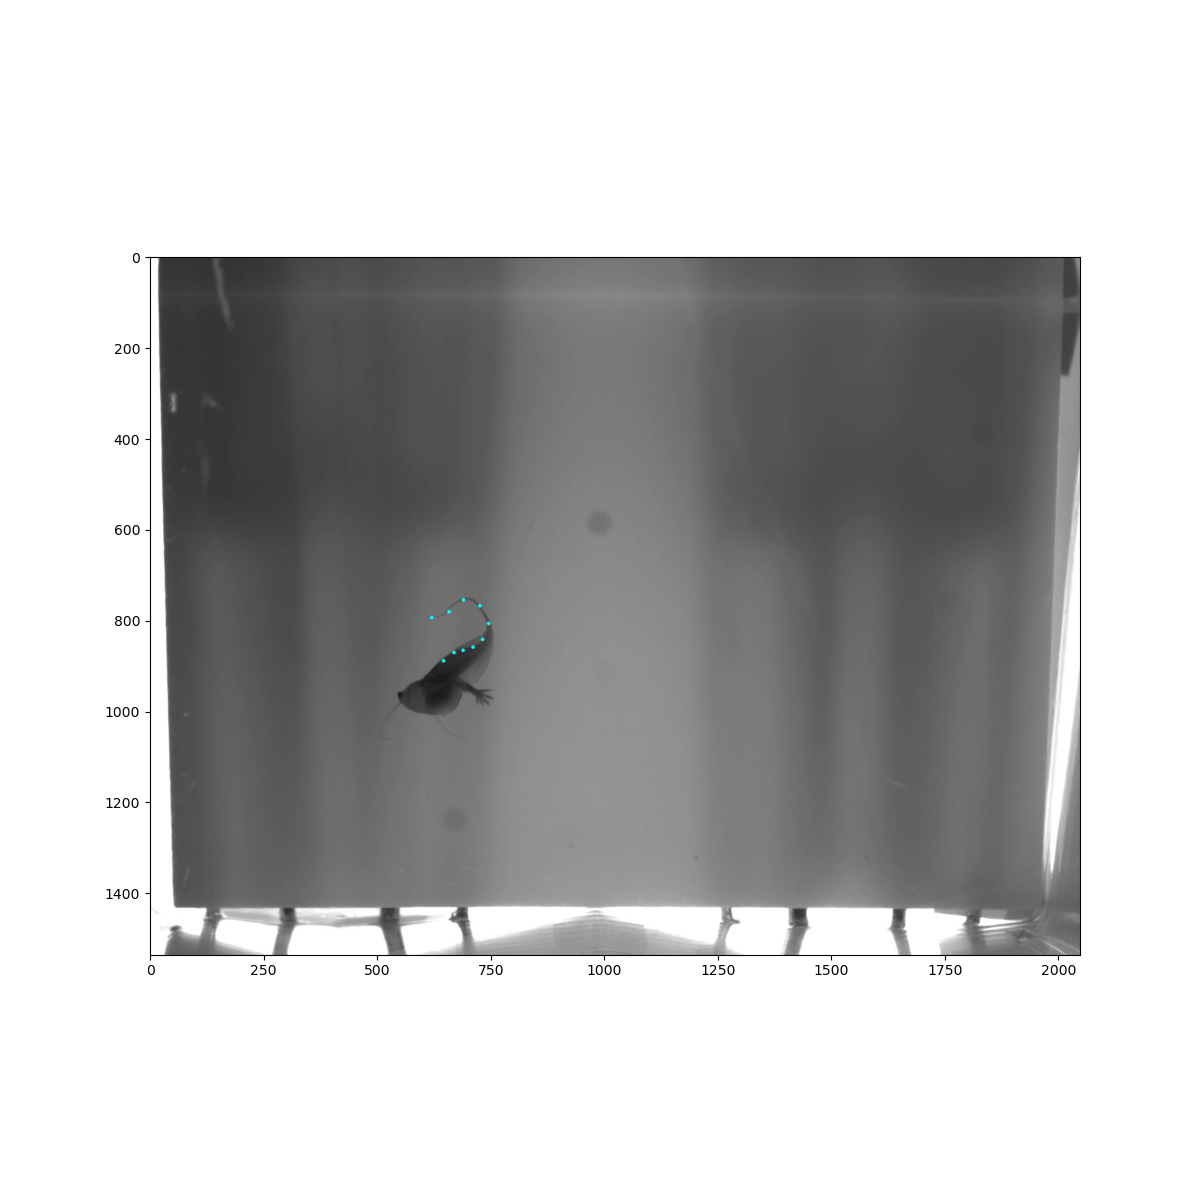

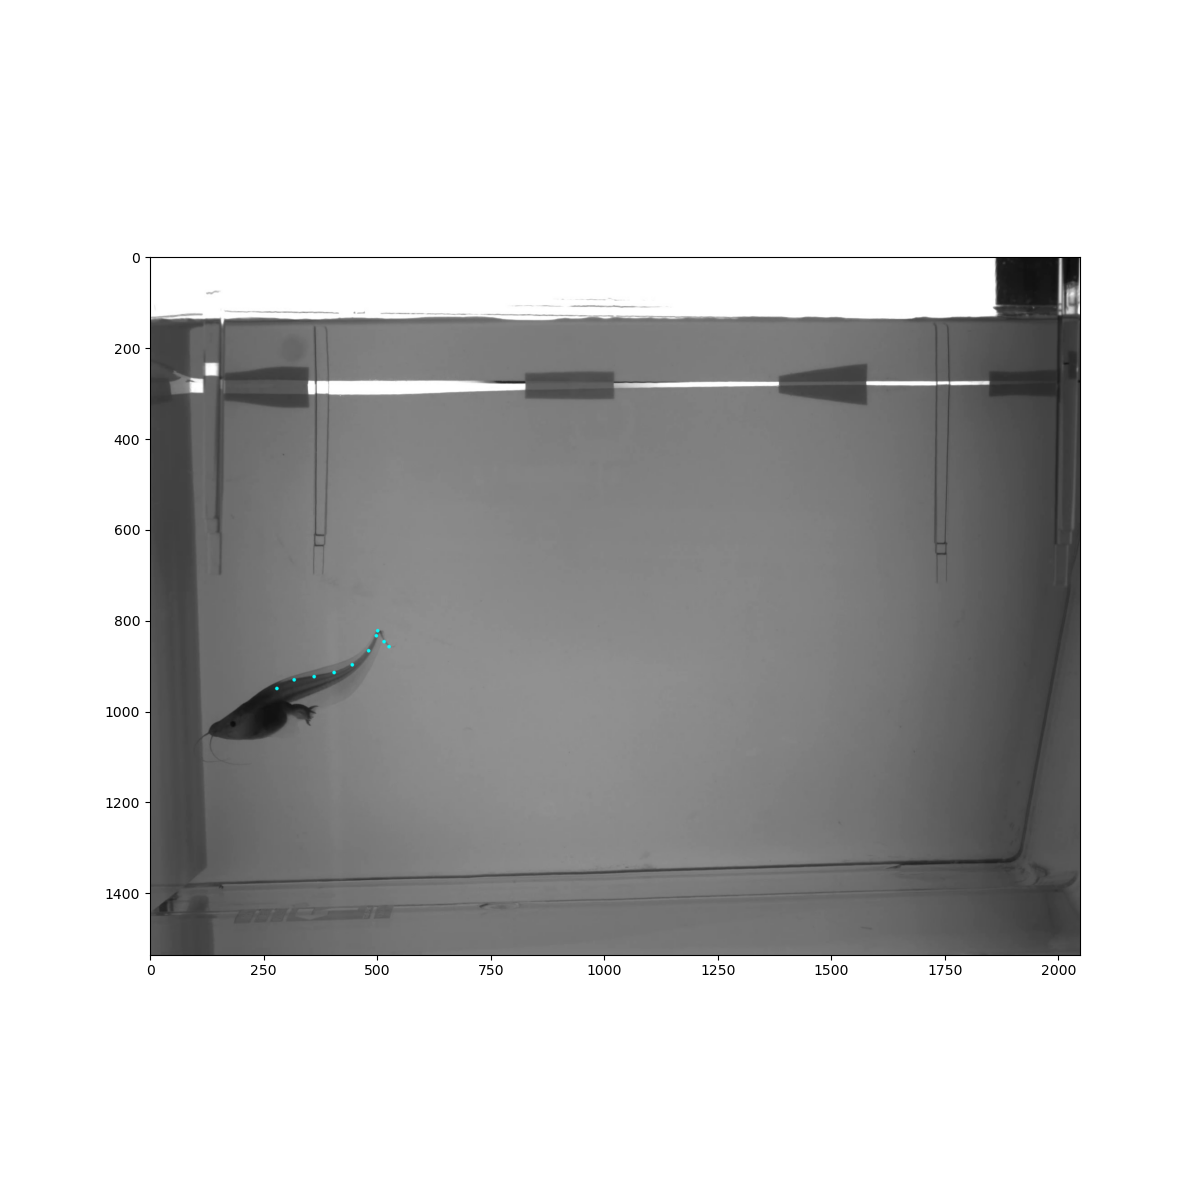

In [123]:
fig, ax = plt.subplots(figsize = (12,12))
plt.imshow(i0)
fig, ax = plt.subplots(figsize = (12,12))
plt.imshow(i1)
fig, ax = plt.subplots(figsize = (12,12))
plt.imshow(i2)

In [101]:
path_ = '/home/iyer_la/Documents/TailAnnotated/DANNCE/'
files_ = [path_ + i for i in os.listdir(path_) if 'reprojerr' in i]
for fi in files_:
    n = np.load(fi)
    print(max(n))

0.9495804493842683
0.9645193508337178
0.8331500794727507
0.7443229064457397
1.2421486715079832
0.8879897194291728
1.0908532330831546
1.177200080226156
0.9984815650204927
0.7381751239426948
1.0113034968328107
0.8991459177744414
0.98711892768925
1.7222616618988686
0.8746173966514819
1.087615851824931
0.9247026710006674
1.1268564171728128
0.9245183308697775
0.9366984895438648
1.1682734223103313
0.8893358491571075
1.224577474885141
0.8180863065941799
0.870418187564072
0.9337043162406296
0.7720267256122312
1.0525842426222172
0.9747465308585987
0.9845485401655425
1.0462944900381268
0.8587008748603591
0.9063669302899011
0.9567517359484253
1.059702020534803
1.0516351092462481
0.5691285490440889
0.9650247512614245
0.8383188188902053
1.0263688042501735
1.4364913423990109
1.0836497158811025
0.9289338339883436
0.7731215815380137
1.0216543558426108
1.0506139325032242
0.8540922096893483
0.791914652219935
0.8988747048297059
1.0545627567123188
0.9169530904563642
1.1994481332344589
0.8365057116728964
0

In [130]:
for i in range(100): plt.close()